# Buffer Stock Model

This notebooks shows you how to use the tools of the **consav** package to solve the canonical **buffer-stock consumption model** with either

1. **vfi**: standard value function iteration
2. **nvfi**: nested value function iteration
3. **egm**: endogenous grid point method

In all cases, each time step is solved using fully [Numba](http://numba.pydata.org/) just-in-time compilled code. Numba automatically convert Python and NumPy code into fast machine code. Specifically, this is done for all functions preceded (decorated) with ``@njit`` or ``@njit(parallel=True)`` when parallization is used.

**Extra:** See `02. Calling C++.ipynb` for solving the model using C++.

## Model equations

The model's **bellman equation** is given by

$$ 
\begin{aligned}
v_{t}(p_{t},m_{t}) &= \max_{c_t}\frac{c^{1-\rho}}{1-\rho} + \beta v_{t+1}(p_{t+1},m_{t+1}) \\
& \text{s.t.} \\ 
a_{t} &=m_{t}-c_{t} \\
p_{t+1} &=\psi_{t+1} p_{t} \\
\tilde{\xi}_{t+1} &= \begin{cases}
\mu & \text{with prob.}\pi\\
\frac{\xi_{t+1}-\pi\mu}{1-\pi} & \text{else}
\end{cases} \\
m_{t+1} &= R a_{t} + \tilde{\xi}_{t+1}p_{t+1}\\
a_t&\geq 0\\
\end{aligned}
$$

where

$$ \begin{aligned}
\log\psi_{t+1} &\sim \mathcal{N}(-0.5\sigma_{\psi}^{2},\sigma_{\psi}^{2}) \\
\log\xi_{t+1} &\sim \mathcal{N}(-0.5\sigma_{\xi}^{2},\sigma_{\xi}^{2})
\end{aligned}
$$

In the **last period** there is no continuation value

$$ 
\begin{aligned}
v_{T+1}(m_{T+1},p_{t+1}) &= 0
\end{aligned}
$$

The **post-decision** value function is

$$
\begin{aligned}
w_t(p_t,a_t) &= \beta v_{t+1}(m_{t+1},p_{t+1})
\end{aligned} 
$$

The **Euler-equation** (required when solving with EGM) is 

$$ 
\begin{aligned}
C_{t}^{-\rho} &= q_t(p_t,a_t) \\
 &= \beta R \mathbb{E}_t[C_{t+1}(p_{t+1},m_{t+1})^{-\rho}] 
\end{aligned}
$$

where $q_t(p_t,a_t)$ is the post-decision marginal value of cash.

## Overview

The model solved in this notebook is written in **BufferStockModel.py**. 

It provides a class called **BufferStockModelClass** inheriting its basic interface from the **ModelClass** (from **consav**). 

A short **overview** of the interface is:

1. The class must have a **name** and must contain **three central methods**: 

    1. `settings()` Choose fundamental settings (called *first* when initializing).<br/><br/>
    
        1. `namespaces (list of str)`: In addition to `.par`, `.sol`, `.sim`, each element will be available as an attribute (can be used in numba jitted functions).
        2. `other_attrs (list of str)`: Other attributes to be saved (can *not* be used in numba jitted functions).
        3. `savefolder (str)`: Folder to save the model in.
        4. `not_float list of str)`: List of non-float elements in the namespaces (ensures safe type inference).<br><br>
    
    2. `setup()`: Set baseline parameters (called *second* when initializing).
    3. `allocate()`: Create grids and allocate solution and simulation memory (called *third* when initializing).<br/><br/>
2. **Type-inference:** When initializing the model the `settings()`, `setup()` and `allocate()` methods are called, and the types of all variables in the namespaces are inferred. Results can be seen by `print(model)`. *Types and number of dimensions in arrays must not change afterwards.* 
3. The **solve()** method solves the model
4. The **simulate()** method simulates the model
5. The **save()** method saves the model naming it **savefolder/name**
6. The **copy()** makes a deep copy of the model

In addition to **BufferStockModel.py**, this folder contains the following files:

1. **last_period.py**: calculate consumption and value function in last period
2. **utility.py**: utility function and marginal utility function
3. **post_decision.py**: calcualte $w$ and $q$
4. **vfi.py**: solve with value function iteration
5. **nvfi.py**: solve with nested value function iteration
6. **egm.py**: solve with the endogenous grid method
7. **simulate.py**: simulate for all solution methods
8. **figs.py**: plot figures

The functions in these modules are loaded in **BufferStockModel.py**.

The folder **cppfuncs** contains C++ functions not used in this notebook.

# Setup

In [1]:
# load the BufferStockModel module
from BufferStockModel import BufferStockModelClass

In [2]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb

# load the BufferStockModel module
from BufferStockModel import BufferStockModelClass

# for timing
from consav.misc import elapsed

In [3]:
nb.set_num_threads(1) # use a single thread for clarity

# First Example

The code is easiest to understand for **nvfi** and **do_simple_w = True**. The cell below solves the model using these settings. Go through the code this  cell is calling to understand the interface.

In [4]:
# a. setup 
model = BufferStockModelClass(name='baseline',par={'solmethod':'nvfi'})

# name: required
# **kwargs: par={}, update parameters in .par AFTER calling .setup

# b. print
print('### print the model ###')
print('')
print(model)

# c. solve
print('### solve and simulate the model ###')
print('')
model.solve()

# d. simulate
print('')
model.simulate()

# e. save
model.save()       

### print the model ###

Modelclass: BufferStockModelClass
Name: baseline

namespaces: ['sol', 'par', 'sim']
other_attrs: []
savefolder: saved
cpp_filename: None

sol:
 c = ndarray with shape = (60, 400, 600) [dtype: float64]
 v = ndarray with shape = (60, 400, 600) [dtype: float64]
 w = ndarray with shape = (400, 800) [dtype: float64]
 q = ndarray with shape = (400, 800) [dtype: float64]
 memory, gb: 0.2

par:
 solmethod = nvfi [str]
 T = 60 [int]
 beta = 0.96 [float]
 Delta_dispersion = 0.01 [float]
 beta_min = 0.95 [float]
 beta_max = 0.97 [float]
 betas = ndarray with shape = (3,) [dtype: float64]
 Tmin = 20 [int]
 Tr = 40 [int]
 L = ndarray with shape = (59,) [dtype: float64]
 beta_w = ndarray with shape = (3,) [dtype: float64]
 rho = 2.0 [float]
 tax_rate = 0.0 [float]
 R = 1.03 [float]
 sigma_psi = 0.1 [float]
 Npsi = 6 [int]
 sigma_xi = 0.1 [float]
 Nxi = 6 [int]
 pi = 0.1 [float]
 mu = 0.5 [float]
 Nm = 600 [int]
 Np = 400 [int]
 Na = 800 [int]
 tol = 1e-08 [float]
 do_print =

## Load/save

**Delete** the model:

In [5]:
del model

**Load** the model again:

In [6]:
model_loaded = BufferStockModelClass(name='baseline',load=True)

**Plot** the consumption function in period $t=0$:

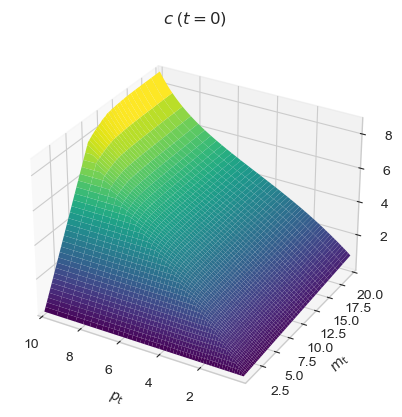

In [7]:
model_loaded.consumption_function(t=0)

**Copy** the model:

In [8]:
model_copy = model_loaded.copy() # name can be specified
print(model_copy.name)

baseline_copy


**Plot** the life-cycle profiles:

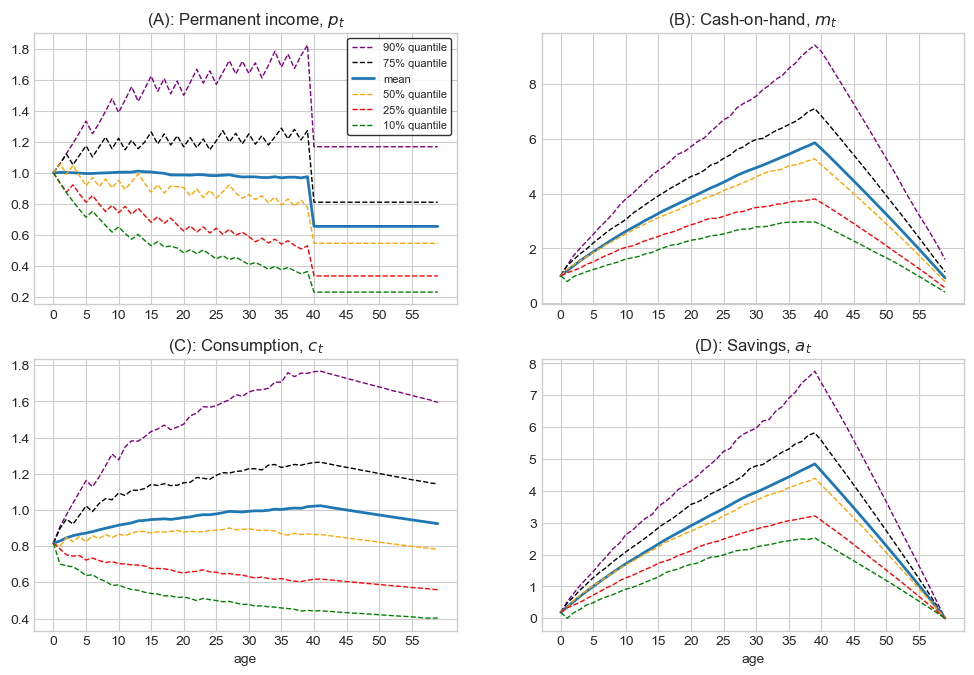

In [10]:
model_copy.lifecycle()

**Plot** an interactive version of the consumption function:

In [ ]:
model_loaded.consumption_function_interact()

# Timings

**Time** the various solution methods and show the importance of the optimized computation of $q_t(p_t,a_t)$ in EGM (i.e. setting `do_simple_w = False`).

In [ ]:
t0 = time.time()
model = BufferStockModelClass(name='')
print(f'time to setup: {elapsed(t0)}')

In [ ]:
for solmethod in ['nvfi','egm','vfi']:    
    for do_simple_w in [True,False]:
        
        if solmethod == 'vfi' and do_simple_w: continue # skip this
    
        print(f'{solmethod}',end='')        
        
        if not solmethod == 'vfi':
            print(f' (do_simple_w = {do_simple_w})')
        else:
            print('')
        
        # a. change solution method
        model.par.solmethod = solmethod
        model.par.do_simple_w = do_simple_w
        model.par.do_print = False
    
        # b. test run 
        t0 = time.time()
        model.solve()
        model.par.do_print = True
        print(f'time in test run: {elapsed(t0)}')

        # c. final run
        t0 = time.time()
        model.solve()
        print(f'time in final run: {elapsed(t0)} [checksum: {model.checksum():.8f}]')
        print('')
        

## Test Parallelization

In [ ]:
threads_list = [x for x in np.arange(1,nb.config.NUMBA_NUM_THREADS+1) if x in [1,4,8] or x%8 == 0]

In [ ]:
solmethod = 'egm'
for do_simple_w in [False,True]:
    
    print(f'{solmethod} (do_simple_w = {do_simple_w}) ')
    
    for threads in threads_list:

        nb.set_num_threads(threads)
        
        # a. change solution method
        model.par.solmethod = solmethod
        model.par.do_simple_w = do_simple_w
        model.par.do_print = False

        # b. run
        t0 = time.time()
        model.solve()
        print(f' time to solve with {threads:2d} threads: {elapsed(t0)} [checksum: {model.checksum():.8f}]')
    
    print('')


**Conclusion:** Numba is not always parallizing that well. And using too many threads can even be harmful.